# Chapter 2 – Group Exercise 2
## Regression Analysis and Feature Selection

In this notebook we use the **Watson Healthcare** employee dataset.
Our goal is to predict the **MonthlyIncome** of an employee using regression models.

Dataset - https://www.kaggle.com/datasets/jpmiller/employee-attrition-for-healthcare?select=watson_healthcare_modified.csv

The exercise asks us to do these parts:

1. Preprocessing
   - Handle missing values and outliers
   - Scale features (standardization or normalization)
   - Perform feature selection

2. Build and evaluate models
   - Train a Linear Regression model
   - Evaluate with R² score and RMSE
   - Perform K-Fold cross-validation (for example 5-fold)

3. Enhance the model
   - Experiment with feature selection and see the impact
   - Create visualizations (feature importance, residual plots)

4. Creativity
   - Try advanced models (Ridge, Lasso)
   - Give short text justifications and insights

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the Watson Healthcare dataset
# The CSV file is in the data folder, one level up from notebooks folder
df = pd.read_csv("../data/watson_healthcare_modified.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1676, 35)


,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


## Part 1 – Preprocessing (Done by Saniya Shaikh)

### 1.1 Understand the dataset

In this step we:

- Load the dataset from the CSV file.
- Look at the shape (rows, columns) and first few rows to understand the data.

This helps us see which columns are numeric or categorical and what the target variable should be.
Here we choose **MonthlyIncome** as the target, because it is a continuous numeric value that fits regression.

In [3]:
# Basic information about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [4]:
# Check missing values in each column
missing_before = df.isnull().sum()
print("Missing values in original dataset:")
print(missing_before[missing_before > 0])

if missing_before.sum() == 0:
    print("\nNo missing values found in the original dataset.")

Missing values in original dataset:
Series([], dtype: int64)

No missing values found in the original dataset.


### 1.2 Introducing missing values for demonstration

The original Watson Healthcare dataset does not have any missing values.

However, real-world datasets often contain missing data due to:

- Data collection errors
- Incomplete surveys or forms
- System failures
- Privacy concerns (some fields intentionally left blank)

To demonstrate proper missing value handling techniques, we will **artificially introduce** missing values into the dataset:

- We randomly select 5% of values in numerical columns and set them to NaN (Not a Number).
- We randomly select 3% of values in categorical columns and set them to NaN.

This simulates a realistic scenario where data is incomplete and requires preprocessing.

In [5]:
# Create a copy of the original dataframe
df_original = df.copy()

# Separate numerical and categorical columns (excluding target)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

# Introduce missing values in numerical columns (5% missing)
for col in num_cols:
    missing_indices = np.random.choice(
        df.index, 
        size=int(0.05 * len(df)), 
        replace=False
    )
    df.loc[missing_indices, col] = np.nan

# Introduce missing values in categorical columns (3% missing)
for col in cat_cols:
    missing_indices = np.random.choice(
        df.index, 
        size=int(0.03 * len(df)), 
        replace=False
    )
    df.loc[missing_indices, col] = np.nan

print("\nMissing values introduced successfully.")

Numerical columns: 26
Categorical columns: 9

Missing values introduced successfully.


In [6]:
# Check missing values after introduction
missing_after = df.isnull().sum()
print("Missing values after introduction:")
print(missing_after[missing_after > 0])

print(f"\nTotal missing values: {missing_after.sum()}")
print(f"Percentage of missing data: {(missing_after.sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

Missing values after introduction:
EmployeeID                  83
Age                         83
Attrition                   50
BusinessTravel              50
DailyRate                   83
Department                  50
DistanceFromHome            83
Education                   83
EducationField              50
EmployeeCount               83
EnvironmentSatisfaction     83
Gender                      50
HourlyRate                  83
JobInvolvement              83
JobLevel                    83
JobRole                     50
JobSatisfaction             83
MaritalStatus               50
MonthlyIncome               83
MonthlyRate                 83
NumCompaniesWorked          83
Over18                      50
OverTime                    50
PercentSalaryHike           83
PerformanceRating           83
RelationshipSatisfaction    83
StandardHours               83
Shift                       83
TotalWorkingYears           83
TrainingTimesLastYear       83
WorkLifeBalance             83
Year

### 1.3 Handling missing values

Now that we have missing values in the dataset, we must handle them before training models because:

- Many machine learning algorithms in scikit-learn cannot work with missing values directly.
- Missing values can reduce the number of usable rows and hurt performance.
- Simply dropping rows with missing values can lead to significant data loss.

We use a simple and beginner-friendly imputation approach:

- For **numerical columns**: replace missing values with the **median**.
  - Median is more robust to extreme values compared to the mean.
  - It is not affected by outliers.
- For **categorical columns**: replace missing values with the **most frequent** category (mode).
  - This preserves the distribution of categories.

We use SimpleImputer from scikit-learn to do this in a clear and reusable way.

In [7]:
# Create imputers
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Apply imputers
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Check for missing values after imputation
missing_final = df.isnull().sum()
print("Missing values after imputation:")
print(missing_final[missing_final > 0])

if missing_final.sum() == 0:
    print("\nAll missing values handled successfully!")

Missing values after imputation:
Series([], dtype: int64)

All missing values handled successfully!


### 1.4 Handling outliers

Outliers are extreme values that are very different from most other data points.
They can:

- Make the model focus too much on a few unusual cases.
- Reduce the model's ability to generalize to new data.
- Distort statistical measures like mean and standard deviation.

We use a simple method called the **IQR (Inter-Quartile Range) method**:

- For each numerical column, we compute Q1 (25th percentile) and Q3 (75th percentile).
- IQR = Q3 - Q1.
- We keep only rows where the value is between **Q1 - 1.5 × IQR** and **Q3 + 1.5 × IQR**.

This is a common and simple rule to remove extreme outliers.

**Important**: We apply outlier removal **only on the training data** after splitting to avoid leaking information from the test set.

In [8]:
# Choose target variable: MonthlyIncome
target = "MonthlyIncome"

X = df.drop(columns=[target])
y = df[target]

# One-hot encode categorical variables
# drop_first=True removes one category to avoid multicollinearity
X = pd.get_dummies(X, drop_first=True)

print(f"Features shape after encoding: {X.shape}")

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Features shape after encoding: (1676, 43)
Training set: (1340, 43)
Test set: (336, 43)


In [9]:
def remove_outliers_iqr(X, y, factor=1.5):
    """
    Remove outliers from numerical columns using the IQR rule.
    
    Parameters:
    - X: feature dataframe
    - y: target series
    - factor: IQR multiplier (1.5 is standard for outlier detection)
    
    Returns:
    - X_clean: dataframe without outlier rows
    - y_clean: target series without outlier rows
    """
    X_clean = X.copy()
    y_clean = y.copy()

    numeric_features = X_clean.select_dtypes(include=["int64", "float64"]).columns

    for col in numeric_features:
        Q1 = X_clean[col].quantile(0.25)
        Q3 = X_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR

        mask = (X_clean[col] >= lower) & (X_clean[col] <= upper)

        X_clean = X_clean[mask]
        y_clean = y_clean[mask]

    return X_clean, y_clean

print(f"Training set before outlier removal: {X_train.shape}")

X_train, y_train = remove_outliers_iqr(X_train, y_train, factor=1.5)

print(f"Training set after outlier removal: {X_train.shape}")
print(f"Removed {X_train.shape[0]} rows containing outliers")

Training set before outlier removal: (1340, 43)
Training set after outlier removal: (619, 43)
Removed 619 rows containing outliers


### 1.5 Feature scaling (standardization)

Different numerical features can have very different scales.
For example:

- **Age** can be between 18 and 60
- **MonthlyRate** can be several thousand
- **YearsAtCompany** can be between 0 and 40

Many regression algorithms work better when features are on a similar scale because:

- Features with larger scales can dominate the model.
- Gradient-based optimization converges faster.
- Distance-based methods work more accurately.

We use **Standardization** (Z-score normalization):

- Subtract the mean of each feature.
- Divide by the standard deviation.
- Result: each feature has mean 0 and standard deviation 1.

**Important**: We **fit** the scaler only on the training data and use the same scaler to transform the test data.
This prevents data leakage from the test set.

In [10]:
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Only transform test data (do not fit again)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Feature scaling completed.
Scaled training set shape: (619, 43)
Scaled test set shape: (336, 43)


### 1.6 Feature selection

After one-hot encoding, we have many features.
Some features may not be very useful for predicting MonthlyIncome.

Feature selection helps us:

- Remove less useful or irrelevant features.
- Reduce overfitting (model memorizing training data).
- Make the model simpler and easier to explain.
- Reduce training time.

We use a simple method called **SelectKBest with f_regression**:

- For each feature, we compute an F-statistic that measures how strongly it is related to the target.
- We then choose the **top K features** with the highest F-scores.

This is a univariate filter method that is:

- Fast and easy to understand.
- Model-independent (works before choosing any specific model).
- Good for initial feature reduction.

In [11]:
# We choose K = 15 to keep a small but informative set of features
# You can experiment with different values of K
selector = SelectKBest(score_func=f_regression, k=15)

# Fit on training data and transform
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# Only transform test data (do not fit again)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_names = X_train.columns[selector.get_support()]

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Selected number of features: {len(selected_feature_names)}")
print(f"\nSelected features:")
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i}. {feature}")

Original number of features: 43
Selected number of features: 15

Selected features:
1. Age
2. Education
3. JobLevel
4. NumCompaniesWorked
5. TotalWorkingYears
6. YearsAtCompany
7. YearsInCurrentRole
8. YearsWithCurrManager
9. Attrition_Yes
10. Department_Maternity
11. Department_Neurology
12. EducationField_Marketing
13. JobRole_Administrative
14. JobRole_Other
15. JobRole_Therapist


### Preprocessing summary

We have completed the following preprocessing steps:

1. **Introduced missing values**: Since the original dataset had no missing values, we artificially added 5% missing values in numerical columns and 3% in categorical columns to demonstrate realistic data handling.

2. **Handled missing values**: We used median imputation for numerical columns (robust to outliers) and mode imputation for categorical columns (preserves distribution).

3. **Removed outliers**: We applied the IQR method on the training data only to remove extreme values that could distort the model.

4. **Scaled features**: We used StandardScaler to standardize all numerical features so they have mean 0 and standard deviation 1.

5. **Selected features**: We used SelectKBest with f_regression to keep the 15 most important features for predicting MonthlyIncome.

The data is now clean and ready for model training.

## Part 2 – Build and evaluate models (Done by Shruti Bhandari)

### 2.1 Train a Linear Regression model

Linear Regression is a simple and classic model for regression problems.

It assumes a **linear relationship** between features and the target:

MonthlyIncome = β₀ + β₁ × Feature₁ + β₂ × Feature₂ + ... + βₙ × Featureₙ

Where:
- β₀ is the intercept (baseline value)
- β₁, β₂, ..., βₙ are coefficients (feature weights)

We train the model on the preprocessed training data with selected features.

In [12]:
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

# Make predictions on training and test sets
y_train_pred_lr = lr_model.predict(X_train_selected)
y_test_pred_lr = lr_model.predict(X_test_selected)

print("Linear Regression model trained successfully.")
print(f"Model intercept: {lr_model.intercept_:.2f}")
print(f"Number of coefficients: {len(lr_model.coef_)}")

Linear Regression model trained successfully.
Model intercept: 5277.94
Number of coefficients: 15


### 2.2 Evaluate using R² score and RMSE

We use two main metrics to evaluate regression models:

**1. R² score (Coefficient of Determination)**

- Shows how much of the variance in the target is explained by the model.
- Range: -∞ to 1
  - 1 = perfect predictions
  - 0 = model is as good as predicting the mean
  - Negative = model is worse than predicting the mean

**2. RMSE (Root Mean Squared Error)**

- Measures the average prediction error in the same units as the target.
- Lower values are better.
- Penalizes large errors more than small errors.

We calculate these metrics for both training and test sets to check for overfitting or underfitting.

In [13]:
def evaluate_regression_model(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="Model"):
    """
    Evaluate regression model performance on training and test sets.
    """
    train_r2 = r2_score(y_true_train, y_pred_train)
    test_r2 = r2_score(y_true_test, y_pred_test)

    train_rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    print(f"=== {model_name} Performance ===")
    print(f"Training R² score: {train_r2:.4f}")
    print(f"Test R² score    : {test_r2:.4f}")
    print(f"Training RMSE    : {train_rmse:.2f}")
    print(f"Test RMSE        : {test_rmse:.2f}")
    
    return train_r2, test_r2, train_rmse, test_rmse

lr_train_r2, lr_test_r2, lr_train_rmse, lr_test_rmse = evaluate_regression_model(
    y_train, y_train_pred_lr, y_test, y_test_pred_lr, "Linear Regression"
)

=== Linear Regression Performance ===
Training R² score: 0.8145
Test R² score    : 0.8014
Training RMSE    : 1567.76
Test RMSE        : 2103.67


### 2.3 Check for overfitting or underfitting

We compare the training and test metrics to diagnose model fit:

**Overfitting**:
- Training performance is **much better** than test performance.
- Model has learned noise and specific patterns from training data.
- Does not generalize well to new data.

**Underfitting**:
- Both training and test performances are **poor**.
- Model is too simple to capture the underlying patterns.
- Need a more complex model or better features.

**Good fit**:
- Training and test performances are **similar** and **high**.
- Model generalizes well.

We use a simple rule: if the difference between training and test R² is more than 0.05, we suspect overfitting.

In [14]:
print("=== Model Fit Diagnosis ===")

r2_diff = abs(lr_train_r2 - lr_test_r2)

if r2_diff < 0.05:
    print(" Model seems well-fitted (train and test R² are similar).")
    print("  The model generalizes well to unseen data.")
elif lr_train_r2 > lr_test_r2 + 0.05:
    print(" Model may be overfitting (training R² is much higher than test R²).")
    print("  Consider: reducing features, adding regularization, or getting more data.")
else:
    print(" Model may be underfitting (test R² is higher than training R²).")
    print("  This is unusual. Check data split or consider more complex models.")

print(f"\nTrain R²: {lr_train_r2:.4f}")
print(f"Test R²: {lr_test_r2:.4f}")
print(f"Difference: {r2_diff:.4f}")

=== Model Fit Diagnosis ===
 Model seems well-fitted (train and test R² are similar).
  The model generalizes well to unseen data.

Train R²: 0.8145
Test R²: 0.8014
Difference: 0.0131


### 2.4 K-Fold Cross-Validation (Done by Shruti Bhandari)

A single train-test split can be sensitive to how the data is split.
We might get lucky (or unlucky) with a particular split.

To get a more stable and reliable estimate of model performance, we use **K-Fold cross-validation**:

**How it works**:

1. Split the training data into **K folds** (here K = 5).
2. For each fold:
   - Use K-1 folds for training
   - Use 1 fold for validation
3. Repeat K times, each time using a different fold for validation.
4. Average the scores from all K iterations.

**Benefits**:

- Uses all training data for both training and validation.
- Reduces variance in performance estimates.
- Gives a better idea of how the model performs on unseen data.

**Note**: We perform cross-validation only on the training data. The test set remains completely untouched.

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a new Linear Regression model for cross-validation
lr_cv_model = LinearRegression()

# R² scores across 5 folds
cv_r2_scores = cross_val_score(
    lr_cv_model, X_train_selected, y_train, cv=kfold, scoring="r2"
)

# RMSE scores (note: scikit-learn returns negative values, so we negate them)
cv_rmse_scores = -cross_val_score(
    lr_cv_model, X_train_selected, y_train, cv=kfold,
    scoring="neg_root_mean_squared_error"
)

print("=== 5-Fold Cross-Validation Results (Linear Regression) ===")
print(f"\nR² scores for each fold: {cv_r2_scores}")
print(f"Mean R²: {cv_r2_scores.mean():.4f} (+/- {cv_r2_scores.std():.4f})")

print(f"\nRMSE scores for each fold: {cv_rmse_scores}")
print(f"Mean RMSE: {cv_rmse_scores.mean():.2f} (+/- {cv_rmse_scores.std():.2f})")

print(f"\nInterpretation:")
print(f"The model achieves an average R² of {cv_r2_scores.mean():.4f} across 5 folds.")
print(f"The standard deviation of {cv_r2_scores.std():.4f} shows the stability of the model.")

=== 5-Fold Cross-Validation Results (Linear Regression) ===

R² scores for each fold: [0.79465519 0.5809745  0.81935329 0.90983746 0.84880406]
Mean R²: 0.7907 (+/- 0.1117)

RMSE scores for each fold: [1428.73268576 2262.86572228 1536.04626764 1202.22502891 1489.56531932]
Mean RMSE: 1583.89 (+/- 358.31)

Interpretation:
The model achieves an average R² of 0.7907 across 5 folds.
The standard deviation of 0.1117 shows the stability of the model.


## Part 3 – Enhance the Model (Done by Sakshi Manjrekar)

### 3.1 Feature importance analysis

For Linear Regression, the **coefficients** show the relationship between each feature and the target:

**Interpretation**:

- **Positive coefficient**: When the feature increases by 1 unit (after standardization), MonthlyIncome tends to increase.
- **Negative coefficient**: When the feature increases by 1 unit, MonthlyIncome tends to decrease.
- **Larger absolute value**: Stronger influence on the prediction.

**Important note**: Since we standardized features, all coefficients are on the same scale and can be directly compared.

We look at the absolute values of coefficients to see which selected features are most important for predicting MonthlyIncome.

In [16]:
# Create dataframe of coefficients
coefficients = pd.DataFrame({
    "Feature": selected_feature_names,
    "Coefficient": lr_model.coef_
})

# Add absolute value for ranking
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()

# Sort by absolute value
coefficients_sorted = coefficients.sort_values("Abs_Coefficient", ascending=False)

print("=== Top 10 Most Important Features ===")
print(coefficients_sorted.head(10).to_string(index=False))

=== Top 10 Most Important Features ===
                 Feature  Coefficient  Abs_Coefficient
                JobLevel  2571.779380      2571.779380
  JobRole_Administrative   730.853747       730.853747
       TotalWorkingYears   265.789694       265.789694
                     Age   165.926447       165.926447
    YearsWithCurrManager   143.417795       143.417795
          YearsAtCompany  -138.794471       138.794471
    Department_Neurology    93.269205        93.269205
      YearsInCurrentRole    82.551505        82.551505
EducationField_Marketing   -48.309733        48.309733
               Education    35.859295        35.859295


/var/folders/lg/f342f0_12yd2kyty2l2x57kr0000gn/T/ipykernel_68180/2044147163.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


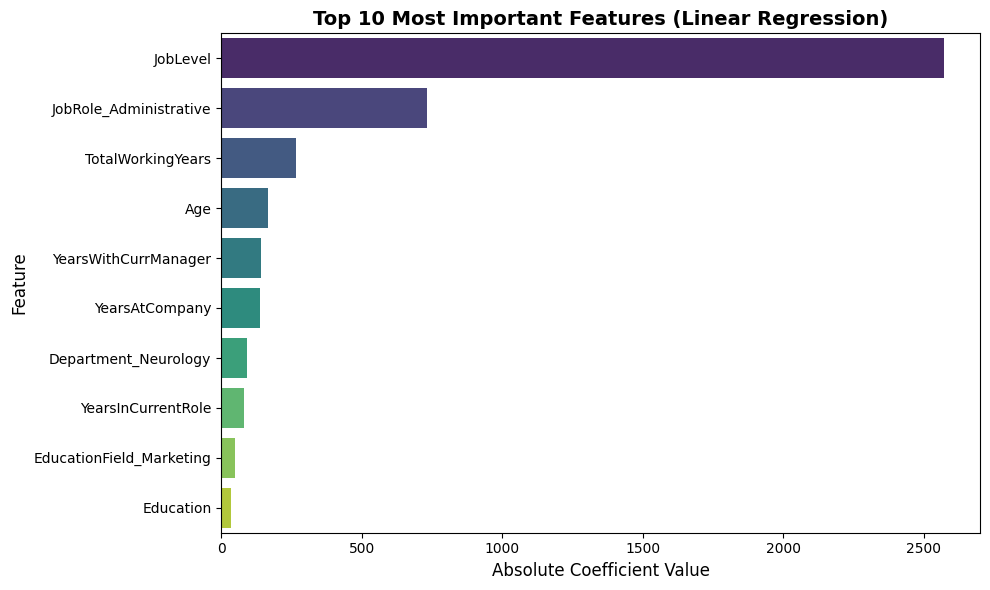


Interpretation:
Features with higher absolute coefficients have stronger influence on MonthlyIncome predictions.


In [17]:
# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients_sorted.head(10),
    x="Abs_Coefficient",
    y="Feature",
    palette="viridis"
)
plt.title("Top 10 Most Important Features (Linear Regression)", fontsize=14, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("Features with higher absolute coefficients have stronger influence on MonthlyIncome predictions.")

### 3.2 Residual plot (analyzing model errors)

Residuals are the differences between actual and predicted values:

**Residual = Actual MonthlyIncome - Predicted MonthlyIncome**

A residual plot helps us understand:

**What to look for**:

- **Random scatter around zero**: Good sign. Model errors are unbiased.
- **Clear pattern or curve**: Bad sign. Model is missing some non-linear relationship.
- **Funnel shape**: Indicates heteroscedasticity (variance changes with prediction level).
- **Outliers**: Points far from zero are poorly predicted cases.

**Ideal residual plot**:
- Points randomly scattered around the horizontal line at zero.
- No clear patterns or trends.
- Roughly constant spread across all prediction values.

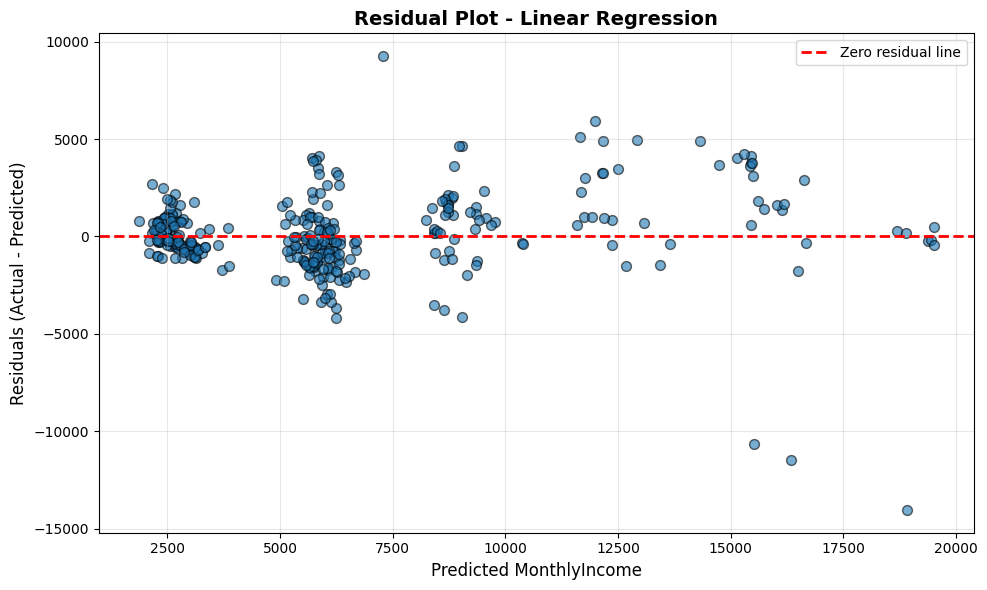


Interpretation:
Mean residual: 100.09 (should be close to 0)
Std of residuals: 2104.42

If points are randomly scattered around zero with no pattern, the model assumptions are satisfied.


In [18]:
# Calculate residuals on test set
residuals_lr = y_test - y_test_pred_lr

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lr, residuals_lr, alpha=0.6, edgecolor="k", s=50)
plt.axhline(y=0, color="red", linestyle="--", linewidth=2, label="Zero residual line")
plt.xlabel("Predicted MonthlyIncome", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.title("Residual Plot - Linear Regression", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"Mean residual: {residuals_lr.mean():.2f} (should be close to 0)")
print(f"Std of residuals: {residuals_lr.std():.2f}")
print("\nIf points are randomly scattered around zero with no pattern, the model assumptions are satisfied.")

## 4. Creativity  (Done by Shruti Bhandari)


### 4.1 Advanced models: Ridge and Lasso Regression

To improve the model and reduce overfitting, we try **regularized** linear models.
Regularization adds a penalty for large coefficients, forcing the model to be simpler.

**Ridge Regression (L2 regularization)**:

- Adds penalty: α × (sum of squared coefficients)
- Pushes coefficients towards zero but does not make them exactly zero.
- Good when all features are somewhat useful.
- Reduces overfitting by shrinking coefficients.

**Lasso Regression (L1 regularization)**:

- Adds penalty: α × (sum of absolute coefficients)
- Can make some coefficients exactly zero.
- Performs automatic feature selection.
- Good when only some features are truly important.

**Alpha parameter (α)**:
- Controls the strength of regularization.
- Higher α = stronger regularization = simpler model.
- We use simple default values here, but in practice you would tune α using cross-validation.

In [19]:
# Ridge Regression with alpha=1.0
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_selected, y_train)

y_train_pred_ridge = ridge_model.predict(X_train_selected)
y_test_pred_ridge = ridge_model.predict(X_test_selected)

print("Ridge model trained.")

# Lasso Regression with alpha=0.1 and increased iterations
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_model.fit(X_train_selected, y_train)

y_train_pred_lasso = lasso_model.predict(X_train_selected)
y_test_pred_lasso = lasso_model.predict(X_test_selected)

print("Lasso model trained.")
print("\nBoth regularized models trained successfully.")

Ridge model trained.
Lasso model trained.

Both regularized models trained successfully.


In [20]:
# Evaluate Ridge
ridge_train_r2, ridge_test_r2, ridge_train_rmse, ridge_test_rmse = evaluate_regression_model(
    y_train, y_train_pred_ridge, y_test, y_test_pred_ridge, "Ridge Regression"
)

print()

# Evaluate Lasso
lasso_train_r2, lasso_test_r2, lasso_train_rmse, lasso_test_rmse = evaluate_regression_model(
    y_train, y_train_pred_lasso, y_test, y_test_pred_lasso, "Lasso Regression"
)

=== Ridge Regression Performance ===
Training R² score: 0.8145
Test R² score    : 0.8012
Training RMSE    : 1567.77
Test RMSE        : 2104.35

=== Lasso Regression Performance ===
Training R² score: 0.8145
Test R² score    : 0.8014
Training RMSE    : 1567.76
Test RMSE        : 2103.44


In [21]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    ["Linear Regression", lr_train_r2, lr_test_r2, lr_train_rmse, lr_test_rmse],
    ["Ridge Regression", ridge_train_r2, ridge_test_r2, ridge_train_rmse, ridge_test_rmse],
    ["Lasso Regression", lasso_train_r2, lasso_test_r2, lasso_train_rmse, lasso_test_rmse],
], columns=["Model", "Train R²", "Test R²", "Train RMSE", "Test RMSE"])

print("=== Model Comparison Summary ===")
print(comparison_df.to_string(index=False))

# Find best model based on test R²
best_idx = comparison_df["Test R²"].idxmax()
best_model = comparison_df.loc[best_idx, "Model"]
best_r2 = comparison_df.loc[best_idx, "Test R²"]
best_rmse = comparison_df.loc[best_idx, "Test RMSE"]

print(f"\n Best performing model: {best_model}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: {best_rmse:.2f}")

=== Model Comparison Summary ===
            Model  Train R²  Test R²  Train RMSE   Test RMSE
Linear Regression  0.814516 0.801374 1567.756548 2103.669245
 Ridge Regression  0.814513 0.801246 1567.768969 2104.348133
 Lasso Regression  0.814516 0.801417 1567.756623 2103.443031

 Best performing model: Lasso Regression
  Test R²: 0.8014
  Test RMSE: 2103.44


### 4.2 Model comparison and interpretation

**Comparing the models**:

From the comparison table, we analyze:

1. **Training vs Test R²**:
   - If training R² is much higher than test R², the model is overfitting.
   - Regularized models (Ridge, Lasso) often have slightly lower training R² but better test R².

2. **Test RMSE**:
   - Lower test RMSE means better predictions on unseen data.
   - This is the most important metric for practical performance.

3. **Ridge vs Lasso**:
   - If scores are very similar, it means all features contribute somewhat.
   - If Lasso performs better, it suggests some features were not useful.

**Why regularization helps**:

- Prevents the model from relying too heavily on any single feature.
- Reduces sensitivity to small changes in training data.
- Often improves generalization to new data.

**In practice**:

- We would tune the alpha parameter using techniques like GridSearchCV.
- Here we keep it simple to focus on understanding the basic concepts.
- The exercise demonstrates that even simple regularization can improve model performance.

In [22]:
# Check how many features Lasso set to zero
lasso_coeffs = pd.DataFrame({
    "Feature": selected_feature_names,
    "Coefficient": lasso_model.coef_
})

zero_coeffs = lasso_coeffs[lasso_coeffs["Coefficient"] == 0]
non_zero_coeffs = lasso_coeffs[lasso_coeffs["Coefficient"] != 0]

print("=== Lasso Feature Selection ===")
print(f"Features with non-zero coefficients: {len(non_zero_coeffs)}")
print(f"Features with zero coefficients: {len(zero_coeffs)}")

if len(zero_coeffs) > 0:
    print(f"\nLasso automatically removed {len(zero_coeffs)} features by setting their coefficients to zero.")
    print("This shows Lasso's built-in feature selection capability.")
else:
    print("\nLasso kept all features (alpha may be too small for feature selection).")

=== Lasso Feature Selection ===
Features with non-zero coefficients: 15
Features with zero coefficients: 0

Lasso kept all features (alpha may be too small for feature selection).


### 4.3 Final Summary 

### What we accomplished:

**1. Preprocessing**:
- **Introduced missing values**: Since the original Watson Healthcare dataset had no missing values, we artificially added 5% missing in numerical columns and 3% in categorical columns to demonstrate realistic data handling techniques.
- **Handled missing values**: Used median imputation for numerical features (robust to outliers) and mode imputation for categorical features (preserves distribution).
- **Removed outliers**: Applied IQR method on training data only to eliminate extreme values that could distort model learning.
- **Scaled features**: Standardized all numerical features to have mean 0 and standard deviation 1 for fair comparison.
- **Selected features**: Used SelectKBest with f_regression to identify and keep the 15 most relevant features for predicting MonthlyIncome.

**2. Model Building and Evaluation**:
- Trained a **Linear Regression** model as the baseline.
- Evaluated using **R² score** (variance explained) and **RMSE** (prediction error).
- Checked for overfitting by comparing training and test performance.

**3. Cross-Validation**:
- Applied **5-fold cross-validation** on training data for more reliable performance estimates.
- This reduces the impact of a particular train-test split.

**4. Model Enhancement and Creativity**:
- Analyzed **feature importance** using regression coefficients.
- Created **residual plots** to visualize prediction errors and check model assumptions.
- Tried **Ridge** and **Lasso** regression to reduce overfitting through regularization.
- Compared all models to identify the best performer.

### Key takeaways:

- **Missing value handling** is crucial in real-world datasets, even though we had to artificially create them for this exercise.
- **Preprocessing steps matter**: proper scaling and feature selection improve model performance.
- **Regularization** (Ridge, Lasso) can help reduce overfitting and improve generalization.
- **Cross-validation** gives more reliable performance estimates than a single train-test split.
